In [140]:
import pandas as pd
import numpy as np
import re
import random
import seaborn as sns

## Data cleaning

In [4]:
data = pd.read_csv('flight_info.csv')
data.head()

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4


In [5]:
# collect the circle flight range
def filter_and_create_new_df(dataframe, column_name):
    filtered_rows = []

    for _, row in dataframe.iterrows():
        cell_value = row[column_name]
        chinese_words = re.findall('[\u4e00-\u9fff]', str(cell_value))  #recognize the chinese word
        
        if len(chinese_words) >= 2 and chinese_words[0] == chinese_words[-1]:
            filtered_rows.append(1)
        else:
            filtered_rows.append(0)

    new_dataframe = dataframe.copy()
    new_dataframe['Result'] = filtered_rows

    return new_dataframe[new_dataframe['Result'] == 1].reset_index(drop=True)

# 
df1 = filter_and_create_new_df(data, 'Range')
df1.head()


,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1


In [6]:
# collect the non-circle flight range
def filter_and_create_new_df(dataframe, column_name):
    filtered_rows = []

    for _, row in dataframe.iterrows():
        cell_value = row[column_name]
        chinese_words = re.findall('[\u4e00-\u9fff]', str(cell_value))  
        
        if len(chinese_words) >= 2 and chinese_words[0] == chinese_words[-1]:
            filtered_rows.append(1)
        else:
            filtered_rows.append(0)

    new_dataframe = dataframe.copy()
    new_dataframe['Result'] = filtered_rows

    return new_dataframe[new_dataframe['Result'] == 0].reset_index(drop=True)

# 
df2 = filter_and_create_new_df(data, 'Range')
df2.head()


,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,8732,8L8L9971,昆,320,昆琼,2022/9/1 7:05,2022/9/1 8:58,1:53,4,0
1,2022/9/1,6959,8L8L9904,昆,320,昆纳,2022/9/1 14:03,2022/9/1 15:06,1:03,4,0
2,2022/9/1,6943,8L8L9903,昆,320,纳昆,2022/9/1 15:08,2022/9/1 16:08,1:01,4,0
3,2022/9/1,1361,8L8L9973,昆,3NE,昆琼,2022/9/1 20:16,2022/9/1 21:58,1:42,4,0
4,2022/9/2,1563,8L8L9903/8L9953/8L9954,昆,737,纳昆腾昆,2022/9/2 15:14,2022/9/2 23:50,3:16,4,0


In [7]:
# merge flight range as a circle range
def merge_rows_with_matching_chars(dataframe, text_column, time_column, num_column):
    merged_dataframe = pd.DataFrame(columns=dataframe.columns)  # Create an empty DataFrame with the same columns
    
    prev_row = None  # Store the previous row data
    
    for index, row in dataframe.iterrows():
        if prev_row is None:
            prev_row = row
        else:
            curr_range = str(row[text_column])
            prev_range = str(prev_row[text_column])
            
            if curr_range[0] == prev_range[-1] and curr_range[-1] == prev_range[0]:
                merged_row = prev_row.copy()  # Copy the previous row data
                
                # Merge row data
                merged_row[text_column] = prev_range + curr_range # merge range
                merged_row[time_column] = add_time(prev_row[time_column], row[time_column]) #merge flight period
                merged_row[num_column] =  (prev_row[num_column] + row[num_column])/2 # merge employee number
                merged_row['Actual Takeoff2'] = row['Actual Takeoff']
                merged_row['Actual Landing2'] = row['Actual Landing']
                merged_dataframe = pd.concat([merged_dataframe, pd.DataFrame(merged_row).transpose()], ignore_index=True)  # Concatenate the merged row to the new DataFrame
                
                prev_row = None  # Reset previous row data to None
            else:
                merged_dataframe = pd.concat([merged_dataframe, pd.DataFrame(prev_row).transpose()], ignore_index=True)  # Concatenate the previous row to the new DataFrame
                prev_row = row
                

    # Add the last row to the new DataFrame
    if prev_row is not None:
        merged_dataframe = pd.concat([merged_dataframe, pd.DataFrame(prev_row).transpose()], ignore_index=True)
    
    return merged_dataframe

    


def add_time(time1, time2):
    # Perform time addition
    # Assuming time format is "H:MM"
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    total_minutes = (hours1 + hours2) * 60 + (minutes1 + minutes2)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    
    return f"{hours}:{minutes:02d}"


# Assuming 'df' is your original DataFrame
merged_df1 = merge_rows_with_matching_chars(df2, 'Range', 'Flight Period','Number of Crew Members')
merged_df1



,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2
0,2022/9/1,8732,8L8L9971,昆,320,昆琼,2022/9/1 7:05,2022/9/1 8:58,1:53,4,0,NaN,NaN
1,2022/9/1,6959,8L8L9904,昆,320,昆纳纳昆,2022/9/1 14:03,2022/9/1 15:06,2:04,4.0,0,2022/9/1 15:08,2022/9/1 16:08
2,2022/9/1,1361,8L8L9973,昆,3NE,昆琼,2022/9/1 20:16,2022/9/1 21:58,1:42,4,0,NaN,NaN
3,2022/9/2,1563,8L8L9903/8L9953/8L9954,昆,737,纳昆腾昆昆纳,2022/9/2 15:14,2022/9/2 23:50,4:19,4.0,0,2022/9/2 15:36,2022/9/2 16:39
4,2022/9/2,8445,8L8L9610,昆,320,纳丽,2022/9/2 17:55,2022/9/2 19:07,1:17,4,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2022/9/30,5732,8L8L9628,昆,738,昆蜀,2022/9/30 14:58,2022/9/30 16:14,1:16,4,0,NaN,NaN
83,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:32,1:57,4.0,0,2022/9/30 15:47,2022/9/30 16:51
84,2022/9/30,6015,8L8L9543,昆,738,蜀昆,2022/9/30 18:19,2022/9/30 19:43,1:25,4,0,NaN,NaN
85,2022/9/30,6959,8L8L9857/8L9818,昆,320,昆渝丽丽渝昆,2022/9/30 19:46,2022/10/1 0:25,6:23,4.5,0,2022/9/30 20:20,2022/10/1 0:34


In [8]:
# collect the circle flight range from merge data
def filter_and_create_new_df(dataframe, column_name):
    filtered_rows = []

    for _, row in dataframe.iterrows():
        cell_value = row[column_name]
        chinese_words = re.findall('[\u4e00-\u9fff]', str(cell_value))  #recognize the chinese word
        
        if len(chinese_words) >= 2 and chinese_words[0] == chinese_words[-1]:
            filtered_rows.append(1)
        else:
            filtered_rows.append(0)

    new_dataframe = dataframe.copy()
    new_dataframe['Result'] = filtered_rows

    return new_dataframe[new_dataframe['Result'] == 1].reset_index(drop=True)

# 
df3 = filter_and_create_new_df(merged_df1, 'Range')
df3.head()


,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2
0,2022/9/1,6959,8L8L9904,昆,320,昆纳纳昆,2022/9/1 14:03,2022/9/1 15:06,2:04,4.0,1,2022/9/1 15:08,2022/9/1 16:08
1,2022/9/2,1563,8L8L9903/8L9953/8L9954,昆,737,纳昆腾昆昆纳,2022/9/2 15:14,2022/9/2 23:50,4:19,4.0,1,2022/9/2 15:36,2022/9/2 16:39
2,2022/9/3,5407,8L8L9895,昆,738,昆鄂鄂昆,2022/9/3 7:30,2022/9/3 9:37,4:07,4.0,1,2022/9/3 10:43,2022/9/3 12:42
3,2022/9/3,6943,8L8L9904,昆,320,昆纳纳昆,2022/9/3 14:12,2022/9/3 15:12,2:03,4.0,1,2022/9/3 15:09,2022/9/3 16:12
4,2022/9/4,6959,8L8L9903,昆,320,纳昆昆纳,2022/9/4 15:15,2022/9/4 16:39,2:22,4.0,1,2022/9/4 15:40,2022/9/4 16:48


In [9]:
final_data = pd.concat([df1, df3], ignore_index=True)
final_data

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1,NaN,NaN
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1,NaN,NaN
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1,NaN,NaN
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1,NaN,NaN
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 1:19,4:03,4.0,1,2022/9/27 6:44,2022/9/27 8:44
560,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:12,1:52,4.0,1,2022/9/28 15:44,2022/9/28 16:41
561,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 23:29,8:41,4.0,1,2022/9/29 15:12,2022/9/29 16:12
562,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:32,1:57,4.0,1,2022/9/30 15:47,2022/9/30 16:51


In [10]:
flight_period = pd.to_timedelta(final_data['Flight Period'] + ':00')
final_data

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1,NaN,NaN
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1,NaN,NaN
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1,NaN,NaN
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1,NaN,NaN
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 1:19,4:03,4.0,1,2022/9/27 6:44,2022/9/27 8:44
560,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:12,1:52,4.0,1,2022/9/28 15:44,2022/9/28 16:41
561,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 23:29,8:41,4.0,1,2022/9/29 15:12,2022/9/29 16:12
562,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:32,1:57,4.0,1,2022/9/30 15:47,2022/9/30 16:51


In [11]:
final_data.to_csv('final_data.csv', index=False)

## Model Buding

In [13]:
# def Fitness Function
# weight of the workload
x = 0.4  # flight period
y = 0.3  # too early or too late
z = 0.3  # number of crew

# workload function
def calculate_workload(row):
    # calculate the flight period is long or short
    flight_period = pd.to_timedelta(row['Flight Period'] + ':00')
    long_flight = pd.Timedelta(hours=5, minutes=3) #5h3m is the median flight period
    long_flight_time = flight_period > long_flight

    # calculate the takeoff time is too erarly or landing time is too late
    actual_takeoff_time = pd.to_datetime(row['Actual Takeoff'])
    actual_landing_time = pd.to_datetime(row['Actual Landing'])
    early_or_late_count = (actual_takeoff_time.hour < 8) + (actual_landing_time.hour > 20)

    # calculate workload
    workload = 0.4 * long_flight_time + 0.4 * early_or_late_count + 0.2 * row['Number of Crew Members']
    #workload = early_or_late_count
    return workload

# generate the new column named workload
final_data['Workload'] = final_data.apply(calculate_workload, axis=1)

In [14]:
final_data.head()

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2,Workload
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1,NaN,NaN,1.2
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1,NaN,NaN,1.6
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1,NaN,NaN,1.6
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1,NaN,NaN,1.2
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1,NaN,NaN,1.6


In [81]:
data = final_data
data

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2,Workload
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1,NaN,NaN,1.2
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1,NaN,NaN,1.6
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1,NaN,NaN,1.6
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1,NaN,NaN,1.2
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1,NaN,NaN,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 1:19,4:03,4.0,1,2022/9/27 6:44,2022/9/27 8:44,0.8
560,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:12,1:52,4.0,1,2022/9/28 15:44,2022/9/28 16:41,0.8
561,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 23:29,8:41,4.0,1,2022/9/29 15:12,2022/9/29 16:12,1.6
562,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:32,1:57,4.0,1,2022/9/30 15:47,2022/9/30 16:51,0.8


In [95]:
import pandas as pd
import random

# Load the data from the CSV file
data = final_data

# Extract the workload values and the number of crew members from the 'Workload' and 'Number of Crew Members' columns
workloads = data['Workload'].tolist()
num_crew_members = data['Number of Crew Members'].tolist()

# Define the number of workers and works
num_workers = 664
num_works = len(data)

# Define genetic algorithm parameters
population_size = 100
mutation_rate = 0.1
num_generations = 100

def fitness_function(chromosome):
    total_workload = 0
    for i in range(num_workers):
        total_workload += sum(workloads[work] for work in chromosome[i])
    return total_workload

def create_chromosome():
    # Create a list of work indices
    available_works = list(range(num_works))
    chromosome = []

    # Shuffle the list of work indices to ensure randomness
    random.shuffle(available_works)

    for _ in range(num_workers):
        worker_works = []
        while available_works and len(worker_works) < num_crew_members[available_works[0]]:
            worker_works.append(available_works.pop(0))
        chromosome.append(worker_works)

    return chromosome

def mutate(chromosome):
    for i in range(num_workers):
        if random.random() < mutation_rate:
            worker_works = chromosome[i]
            available_works = list(set(range(num_works)) - set(worker_works))
            random.shuffle(available_works)
            while available_works and len(worker_works) < num_crew_members[available_works[0]]:
                worker_works.append(available_works.pop(0))
    return chromosome

def calculate_worker_workload(work_schedule):
    worker_workloads = [sum(workloads[work] for work in worker_works) for worker_works in work_schedule]
    return worker_workloads

def genetic_algorithm():
    # Initialize the population
    population = [create_chromosome() for _ in range(population_size)]

    for generation in range(num_generations):
        # Evaluate the fitness of each chromosome in the population
        fitness_scores = [fitness_function(chromosome) for chromosome in population]

        # Select the top performing chromosomes for reproduction
        num_parents = int(population_size * 0.2)
        parents = [population[i] for i in sorted(range(population_size), key=lambda x: fitness_scores[x], reverse=True)[:num_parents]]

        # Create the next generation through crossover and mutation
        offspring = parents.copy()
        while len(offspring) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1), mutate(child2)])

        population = offspring

    # Select the best performing chromosome (work schedule)
    best_chromosome = max(population, key=fitness_function)
    best_fitness = fitness_function(best_chromosome)

    # Calculate the total workload for each worker
    worker_workloads = calculate_worker_workload(best_chromosome)

    return best_chromosome, best_fitness, worker_workloads

# Run the genetic algorithm
best_schedule, best_fitness, worker_workloads = genetic_algorithm()
print("Best Work Schedule:")
for i, works in enumerate(best_schedule):
    print(f"Worker {i+1}: Works {works}")
print("Total Workload:", best_fitness)

print("\nWorker Workloads:")
for i, workload in enumerate(worker_workloads):
    print(f"Worker {i+1}: Total Workload {workload}")


Best Work Schedule:
Worker 1: Works [39, 184, 16, 193, 307, 339, 554]
Worker 2: Works [216, 117, 460, 111, 148, 488, 548, 554]
Worker 3: Works [232, 437, 541, 458, 464, 146, 396, 554]
Worker 4: Works [287, 227, 267, 535, 444, 139, 396, 554]
Worker 5: Works [538, 534, 44, 337, 17, 146, 396]
Worker 6: Works [206, 494, 519, 530, 235, 146, 554]
Worker 7: Works [330, 496, 202, 219, 493, 176, 548, 554]
Worker 8: Works [116, 502, 55, 462, 19, 279, 554]
Worker 9: Works [112, 132, 342, 378, 463, 488, 396, 554]
Worker 10: Works [327, 507, 433, 332, 563, 146, 548, 554]
Worker 11: Works [557, 419, 189, 360, 488, 139, 548, 554]
Worker 12: Works [86, 399, 255, 257, 307, 339, 554]
Worker 13: Works [42, 435, 197, 516, 91, 146, 396, 554]
Worker 14: Works [527, 416, 343, 377, 463, 441, 396]
Worker 15: Works [448, 345, 528, 235, 91, 441, 554]
Worker 16: Works [453, 270, 467, 473, 118, 385, 396, 554]
Worker 17: Works [238, 456, 303, 89, 488, 554, 548]
Worker 18: Works [12, 417, 317, 440, 19, 139, 396]
Wor

In [96]:

# Create a DataFrame for the best work schedule
worker_schedule_df = pd.DataFrame({'Worker': [f'Worker {i+1}' for i in range(num_workers)],
                                   'Works': ['; '.join([f'Work {work+1}' for work in works]) for works in best_schedule],
                                   'Total Workload': worker_workloads})

# Display the DataFrame
worker_schedule_df


,Worker,Works,Total Workload
0,Worker 1,Work 40; Work 185; Work 17; Work 194; Work 308...,9.5
1,Worker 2,Work 217; Work 118; Work 461; Work 112; Work 1...,12.0
2,Worker 3,Work 233; Work 438; Work 542; Work 459; Work 4...,12.3
3,Worker 4,Work 288; Work 228; Work 268; Work 536; Work 4...,12.7
4,Worker 5,Work 539; Work 535; Work 45; Work 338; Work 18...,10.0
...,...,...,...
659,Worker 660,Work 448; Work 25; Work 229; Work 492; Work 14...,12.7
660,Worker 661,Work 200; Work 318; Work 550; Work 109; Work 1...,11.4
661,Worker 662,Work 425; Work 64; Work 317; Work 264; Work 14...,11.6
662,Worker 663,Work 253; Work 104; Work 540; Work 364; Work 1...,10.7


workload_variance: 1.9254454923767477
Range of Workload: 7.699999999999999
Median Workload: 11.399999999999999
Max Workload: 15.1
Min Workload: 7.4
Workload Balance Ratio: 2.0405405405405403
Average Total Workload: 11.439759036144578


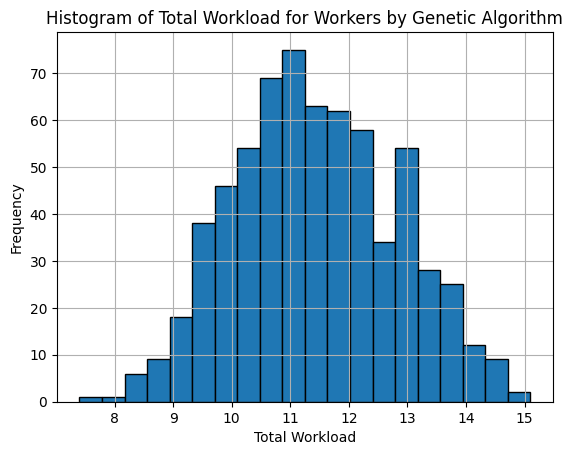

In [150]:
workload_variance = worker_schedule_df['Total Workload'].var()
range_workload = np.ptp(worker_workloads)
median_workload = np.median(worker_workloads)
average_total_workload = np.mean(worker_workloads)

# Calculate the workload balance ratio
max_workload = max(worker_workloads)
min_workload = min(worker_workloads)
workload_balance_ratio = max_workload / min_workload

# Display the metrics
print("workload_variance:", workload_variance)
print("Range of Workload:", range_workload)
print("Median Workload:", median_workload)
print("Max Workload:", max_workload)
print("Min Workload:", min_workload)
print("Workload Balance Ratio:", workload_balance_ratio)
print("Average Total Workload:", average_total_workload)


# Plot the histogram of the total workload for workers
plt.hist(worker_schedule_df['Total Workload'], bins=20, edgecolor='black')
plt.xlabel('Total Workload')
plt.ylabel('Frequency')
plt.title('Histogram of Total Workload for Workers by Genetic Algorithm')
plt.grid(True)
plt.show()

In [128]:
cv1 = np.std(worker_workloads) / average_total_workload
cv1

0.1212052585014103

In [116]:


# Load the data from the CSV file
data = final_data

# Extract the workload values and the number of crew members from the 'Workload' and 'Number of Crew Members' columns
workloads = data['Workload'].tolist()
num_crew_members = data['Number of Crew Members'].tolist()

# Define the number of workers and works
num_workers = 664
num_works = len(data)

def assign_works_randomly():
    # Create a list of work indices
    available_works = list(range(num_works))

    # Shuffle the list of work indices to ensure randomness
    random.shuffle(available_works)

    # Create a list to store the work assignments for each worker
    worker_schedule = [[] for _ in range(num_workers)]

    for work in available_works:
        # Find the required number of workers for the current work
        required_workers = num_crew_members[work]

        # Assign the work to available workers one by one
        assigned_workers = 0
        for worker in worker_schedule:
            if assigned_workers < required_workers and not worker:
                worker.append(work)
                assigned_workers += 1

        # If there are still unassigned workers, randomly assign the work to them
        while assigned_workers < required_workers:
            random_worker = random.randrange(num_workers)
            worker_schedule[random_worker].append(work)
            assigned_workers += 1

    return worker_schedule

def calculate_worker_workload(work_schedule):
    worker_workloads = [sum(workloads[work] for work in worker_works) for worker_works in work_schedule]
    return worker_workloads

# Randomly assign works to workers
random_worker_schedule = assign_works_randomly()

# Calculate the total workload for each worker
worker_workloads2 = calculate_worker_workload(random_worker_schedule)

# Create a DataFrame for the random work schedule
random_worker_schedule_df = pd.DataFrame({'Worker': [f'Worker {i+1}' for i in range(num_workers)],
                                          'Works': ['; '.join([f'Work {work+1}' for work in works]) for works in random_worker_schedule],
                                          'Total Workload2': worker_workloads2})

random_worker_schedule_df


,Worker,Works,Total Workload2
0,Worker 1,Work 472; Work 325,2.4
1,Worker 2,Work 472; Work 148; Work 186; Work 147,4.8
2,Worker 3,Work 472; Work 59; Work 234; Work 524,3.6
3,Worker 4,Work 472; Work 362; Work 374; Work 359,4.8
4,Worker 5,Work 307; Work 137,2.0
...,...,...,...
659,Worker 660,Work 450; Work 74; Work 489,4.4
660,Worker 661,Work 73; Work 560; Work 553,4.0
661,Worker 662,Work 73; Work 517; Work 429,4.4
662,Worker 663,Work 73; Work 353; Work 397; Work 296,6.2


In [151]:
workload_variance2 = random_worker_schedule_df['Total Workload2'].var()
workload_variance2

4.192395623216849

In [119]:
range_workload2 = np.ptp(worker_workloads2)
range_workload2

10.9

In [127]:
cv = np.std(worker_workloads2) / average_total_workload2
cv

0.4719277612367793

workload_variance2: 4.192395623216849
Range of Workload2: 10.9
Median Workload2: 4.0
Max Workload2: 11.700000000000001
Min Workload2: 0.8
Workload Balance Ratio2: 14.625
Average Total Workload2: 4.33539156626506


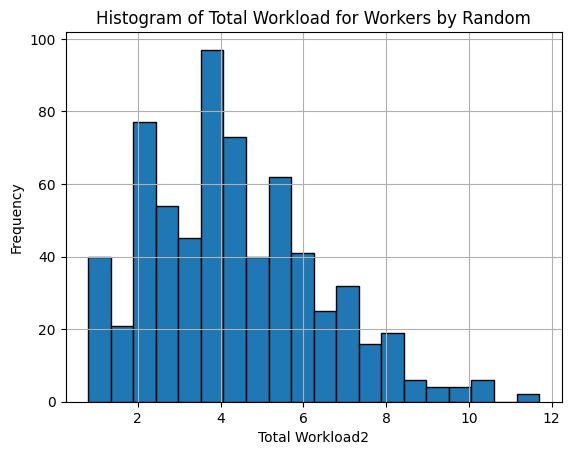

In [152]:
workload_variance2 = random_worker_schedule_df['Total Workload2'].var()
range_workload2 = np.ptp(worker_workloads2)
median_workload2 = np.median(worker_workloads2)
average_total_workload2 = np.mean(worker_workloads2)

# Calculate the workload balance ratio
max_workload2 = max(worker_workloads2)
min_workload2 = min(worker_workloads2)
workload_balance_ratio2 = max_workload2 / min_workload2

# Display the metrics
print("workload_variance2:", workload_variance2)
print("Range of Workload2:", range_workload2)
print("Median Workload2:", median_workload2)
print("Max Workload2:", max_workload2)
print("Min Workload2:", min_workload2)
print("Workload Balance Ratio2:", workload_balance_ratio2)
print("Average Total Workload2:", average_total_workload2)


# Plot the histogram of the total workload for workers
plt.hist(random_worker_schedule_df['Total Workload2'], bins=20, edgecolor='black')
plt.xlabel('Total Workload2')
plt.ylabel('Frequency')
plt.title('Histogram of Total Workload for Workers by Random')
plt.grid(True)
plt.show()

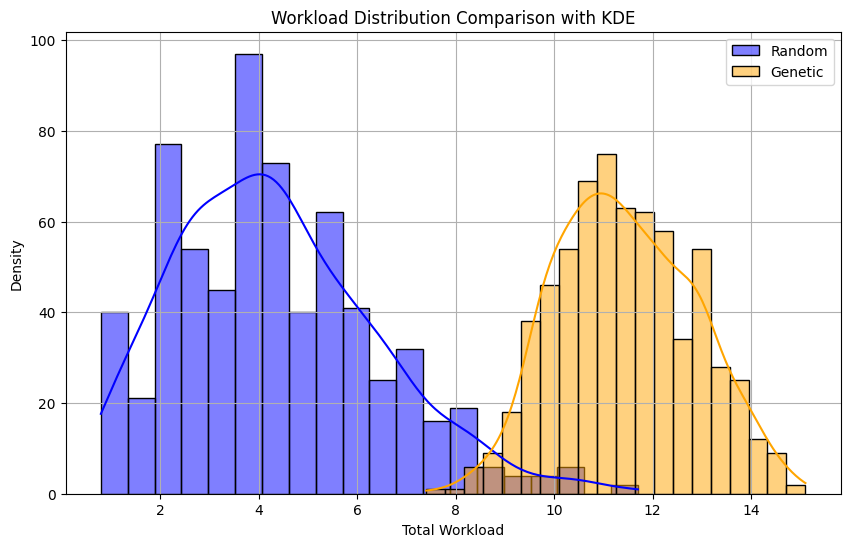

In [145]:
plt.figure(figsize=(10, 6))
sns.histplot(worker_workloads2, kde=True, color='blue', label='Random', alpha=0.5, bins=20)
sns.histplot(worker_workloads, kde=True, color='orange', label='Genetic', alpha=0.5, bins=20)
plt.xlabel('Total Workload')
plt.ylabel('Density')
plt.title('Workload Distribution Comparison with KDE')
plt.legend()
plt.grid(True)
plt.show()

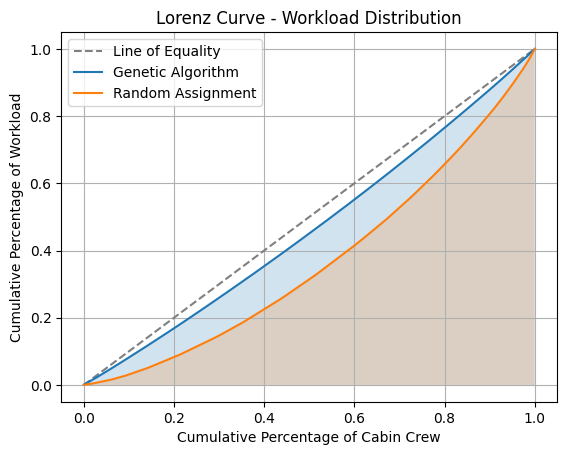

In [138]:


# Assuming you have two lists of total workloads for each person from both methods
# For example:
method1_workloads = worker_schedule_df['Total Workload'] # Total workloads for each person in Method 1
method2_workloads = random_worker_schedule_df['Total Workload2']  # Total workloads for each person in Method 2

def calculate_lorenz_curve(workloads):
    sorted_workloads = np.sort(workloads)
    cumulative_workloads = np.cumsum(sorted_workloads)
    cumulative_percentage = cumulative_workloads / np.sum(workloads)
    return cumulative_percentage

# Calculate the Lorenz curves for each method
method1_lorenz = calculate_lorenz_curve(method1_workloads)
method2_lorenz = calculate_lorenz_curve(method2_workloads)

# Plot the Lorenz curves
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Line of Equality')
plt.plot(np.linspace(0, 1, len(method1_lorenz)), method1_lorenz, label='Genetic Algorithm')
plt.plot(np.linspace(0, 1, len(method2_lorenz)), method2_lorenz, label='Random Assignment')
plt.fill_between(np.linspace(0, 1, len(method1_lorenz)), method1_lorenz, alpha=0.2)
plt.fill_between(np.linspace(0, 1, len(method2_lorenz)), method2_lorenz, alpha=0.2)

# Customize the plot
plt.xlabel('Cumulative Percentage of Cabin Crew')
plt.ylabel('Cumulative Percentage of Workload')
plt.title('Lorenz Curve - Workload Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [155]:
# Assuming you have two lists of total workloads for each person from both methods
# For example:
method1_workloads = worker_schedule_df['Total Workload'] # Total workloads for each person in Method 1
method2_workloads = random_worker_schedule_df['Total Workload2']  # Total workloads for each person in Method 2

def calculate_percentage_difference(workloads1, workloads2):
    percentage_difference = [(w1 - w2) / w2 * 100 for w1, w2 in zip(workloads1, workloads2)]
    return percentage_difference

# Calculate the percentage difference for each worker's workload between the two methods
percentage_difference = calculate_percentage_difference(method1_workloads, method2_workloads)

# Create a DataFrame to display the results
result_df = pd.DataFrame({'Worker': [f'Worker {i+1}' for i in range(len(method1_workloads))],
                          'Method 1 Workload': method1_workloads,
                          'Method 2 Workload': method2_workloads,
                          'Percentage Difference (%)': np.average(percentage_difference)})

# Display the DataFrame
print(result_df)


         Worker  Method 1 Workload  Method 2 Workload  \
0      Worker 1                9.5                2.4   
1      Worker 2               12.0                4.8   
2      Worker 3               12.3                3.6   
3      Worker 4               12.7                4.8   
4      Worker 5               10.0                2.0   
..          ...                ...                ...   
659  Worker 660               12.7                4.4   
660  Worker 661               11.4                4.0   
661  Worker 662               11.6                4.4   
662  Worker 663               10.7                6.2   
663  Worker 664               11.7                4.4   

     Percentage Difference (%)  
0                   252.299591  
1                   252.299591  
2                   252.299591  
3                   252.299591  
4                   252.299591  
..                         ...  
659                 252.299591  
660                 252.299591  
661               

In [146]:
import numpy as np
import scipy.stats as stats

# Assuming you have a list of total workloads for each person
# For example:
workloads = worker_schedule_df['Total Workload']

# Calculate the skewness and kurtosis of the workload distribution
skewness = stats.skew(workloads)
kurtosis = stats.kurtosis(workloads)

# Display the results
print("Genetic Workload Skewness:", skewness)
print("Genetic Workload Kurtosis:", kurtosis)


Genetic Workload Skewness: 0.14147964863048215
Genetic Workload Kurtosis: -0.5266842125498576


In [147]:
import numpy as np
import scipy.stats as stats

# Assuming you have a list of total workloads for each person
# For example:
workloads = random_worker_schedule_df['Total Workload2']

# Calculate the skewness and kurtosis of the workload distribution
skewness = stats.skew(workloads)
kurtosis = stats.kurtosis(workloads)

# Display the results
print("Random Workload Skewness:", skewness)
print("RandomWorkload Kurtosis:", kurtosis)

Random Workload Skewness: 0.6303943044589183
RandomWorkload Kurtosis: 0.2475585970512193


In [148]:
method1_cv = np.std(worker_workloads) / np.mean(worker_workloads)
method2_cv = np.std(worker_workloads2) / np.mean(worker_workloads2)

print("Genetic Coefficient of Variation (CV):", method1_cv)
print("Random Coefficient of Variation (CV):", method2_cv)

Genetic Coefficient of Variation (CV): 0.1212052585014103
Random Coefficient of Variation (CV): 0.4719277612367793
